# Problem 2: Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Mini Facade dataset.

## Setup
First, we will install some required packages for this notebook and download the Mini Facade dataset. 


In [11]:
# install required packages and download the dataset
!pip install colormap easydev pypng
!gdown --fuzzy https://drive.google.com/file/d/1y9lO-_EDo_0MeUx5VJAUoS9nIoG45QSr/view?usp=share_link
!unzip facades.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1y9lO-_EDo_0MeUx5VJAUoS9nIoG45QSr
To: /content/facades.zip
100% 29.6M/29.6M [00:00<00:00, 45.4MB/s]
Archive:  facades.zip
replace __MACOSX/._facades? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

## Dataset
We will create a custom Dataset function for the Mini Facade dataset. You don't have to change anything here.

In [23]:
class FacadeDataset(Dataset):
  def __init__(self, flag, dataDir='./facades/', data_range=(0, 8), n_class=5, 
               onehot=False):
    self.onehot = onehot
    assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
    print("load "+ flag+" dataset start")
    print("    from: %s" % dataDir)
    print("    range: [%d, %d)" % (data_range[0], data_range[1]))
    self.dataset = []
    for i in range(data_range[0], data_range[1]):
      img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

      pngreader = png.Reader(filename=os.path.join(dataDir,flag,
                                                   'eecs442_%04d.png' % i))
      w,h,row,info = pngreader.read()
      label = np.array(list(row)).astype('uint8')

      # Normalize input image
      img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
      # Convert to n_class-dimensional onehot matrix
      label_ = np.asarray(label)
      label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
      for j in range(n_class):
          label[j, :] = label_ == j
      self.dataset.append((img, label))
    print("load dataset done")

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    img, label = self.dataset[index]
    label = torch.FloatTensor(label)
    if not self.onehot:
      label = torch.argmax(label, dim=0)
    else:
      label = label.long()

    return torch.FloatTensor(img), torch.LongTensor(label)

Now, we will create a dataloader for the Mini Facade dataset. You have to play with the size of train-val split and adjust the batch sizes for the splits.

In [25]:
N_CLASS=5
##############################################################################
# TODO: Change data_range so that train_data and val_data splits the 906     #
# samples under "train" folder. You can decide how to split.                 #
#                                                                            # 
# TODO: Adjust batch_size for loaders                                        #
##############################################################################
train_data = FacadeDataset(flag='train', data_range=(0,800), onehot=False)
train_loader = DataLoader(train_data, batch_size=32)
val_data = FacadeDataset(flag='train', data_range=(800,906), onehot=False)
val_loader = DataLoader(val_data, batch_size=32)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

load train dataset start
    from: ./facades/
    range: [0, 800)
load dataset done
load train dataset start
    from: ./facades/
    range: [800, 906)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done


## Model
Design and implement your Convolutional NeuralNetworks to perform semantic segmentation on the Mini Facade dataset. 

You can build a simple neural network based on the U-net [1]:
1. Conv-ReLU-Conv-ReLU that goes from `3 -> 64 -> 64` ( H x W )
2. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/2 x W/2 )
3. Conv-ReLU-Conv-ReLU that goes from `64 -> 128 -> 128` ( H/2 x W/2 )
4. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/4 x W/4 )
5. Conv that goes from `128 -> 128` ( H/4 x W/4 )
6. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H/2 x W/2 )
6. Conv-ReLU-Conv-ReLU that goes from `128 -> 64 -> 64` ( H/2 x W/2 )
7. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H x W )
8. Conv-ReLU-Conv-ReLU that goes from `64 -> 64 -> 5` ( H x W )

Be careful while choosing the kernel size, padding and stride in the convolution layer. You can compute the output shape after a convolution by using the formula:

$$
X_{out} = (X_{in} - K + 2P)/S +1
$$

Where, $X_{out}$ & $X_{in}$ are the output and input shape of the feature map and $K$, $P$ & $S$ are the kernel size, padding and stride repectively.

[1] O. Ronneberger, P. Fischer, and T. Brox, “U-net:  Convolutional networks for biomedical image seg-mentation,”ArXiv, vol. abs/1505.04597, 2015

In [26]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.n_class = N_CLASS
    ########################################################################
    # TODO: Implement a sematic segmentation model                         #
    ########################################################################
    self.layers = nn.Sequential(
            # 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            # 2
            nn.MaxPool2d(2, stride=2),
            # 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            # 4
            nn.MaxPool2d(2, stride=2),
            # 5
            nn.Conv2d(128, 128, 3, padding=1),
            # 6
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # 7
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            # 8
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # 9
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, self.n_class, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

  def forward(self, x):
    ########################################################################
    # TODO: Implement the forward pass                                     #
    ########################################################################
    x = self.layers(x)
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################
    return x

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [27]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,224,224))

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]         147,584
         Upsample-12        [-1, 128, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          73,792
             ReLU-14     

Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

In [28]:
def save_label(label, path):
  '''
  Function for ploting labels.
  '''
  colormap = [
      '#000000',
      '#0080FF',
      '#80FF80',
      '#FF8000',
      '#FF0000',
  ]
  assert(np.max(label)<len(colormap))
  colors = [hex2rgb(color, normalise=False) for color in colormap]
  w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
  with open(path, 'wb') as f:
      w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
  '''
  Function for training.
  '''
  start = time.time()
  running_loss = 0.0
  cnt = 0
  net = net.train()
  for images, labels in tqdm(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    cnt += 1
  end = time.time()
  running_loss /= cnt
  print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
  return running_loss

def test(testloader, net, criterion, device):
  '''
  Function for testing.
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)
      loss = criterion(output, labels)
      losses += loss.item()
      cnt += 1
  print('\n',losses / cnt)
  return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
  '''
  Calculate Average Precision
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    preds = [[] for _ in range(5)]
    heatmaps = [[] for _ in range(5)]
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images).cpu().numpy()
      for c in range(5):
        preds[c].append(output[:, c].reshape(-1))
        heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

    aps = []
    for c in range(5):
      preds[c] = np.concatenate(preds[c])
      heatmaps[c] = np.concatenate(heatmaps[c])
      if heatmaps[c].max() == 0:
        ap = float('nan')
      else:
        ap = ap_score(heatmaps[c], preds[c])
        aps.append(ap)
      print("AP = {}".format(ap))
    print("Average Precision (all classes) = {}".format(np.mean(aps)))
  return None


def get_result(testloader, net, device, folder='output_train'):
  result = []
  cnt = 1
  os.makedirs(folder, exist_ok=True)
  with torch.no_grad():
    net = net.eval()
    cnt = 0
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)[0].cpu().numpy()
      c, h, w = output.shape
      assert(c == N_CLASS)
      y = np.argmax(output, 0).astype('uint8')
      gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
      save_label(y, './{}/y{}.png'.format(folder, cnt))
      save_label(gt, './{}/gt{}.png'.format(folder, cnt))
      plt.imsave('./{}/x{}.png'.format(folder, cnt),
                 ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))
      cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure()
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.45 AP** on the test set


Start training
-----------------Epoch = 1-----------------


100%|██████████| 25/25 [00:30<00:00,  1.20s/it]



 [epoch 1] loss: 1.575 elapsed time 30.265
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



 1.5332879722118378
-----------------Epoch = 2-----------------


100%|██████████| 25/25 [00:30<00:00,  1.21s/it]



 [epoch 2] loss: 1.510 elapsed time 30.209
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.43it/s]



 1.4985466003417969
-----------------Epoch = 3-----------------


100%|██████████| 25/25 [00:29<00:00,  1.18s/it]



 [epoch 3] loss: 1.500 elapsed time 29.590
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]



 1.4981330633163452
-----------------Epoch = 4-----------------


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]



 [epoch 4] loss: 1.491 elapsed time 31.209
Validation loss: 


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]



 1.4463511109352112
-----------------Epoch = 5-----------------


100%|██████████| 25/25 [00:30<00:00,  1.21s/it]



 [epoch 5] loss: 1.377 elapsed time 30.235
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]



 1.3487540781497955
-----------------Epoch = 6-----------------


100%|██████████| 25/25 [00:31<00:00,  1.27s/it]



 [epoch 6] loss: 1.341 elapsed time 31.765
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]



 1.3419654071331024
-----------------Epoch = 7-----------------


100%|██████████| 25/25 [00:30<00:00,  1.23s/it]



 [epoch 7] loss: 1.340 elapsed time 30.772
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



 1.3412130177021027
-----------------Epoch = 8-----------------


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]



 [epoch 8] loss: 1.339 elapsed time 33.616
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



 1.3404741287231445
-----------------Epoch = 9-----------------


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]



 [epoch 9] loss: 1.338 elapsed time 29.165
Validation loss: 


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]



 1.3389505743980408
-----------------Epoch = 10-----------------


100%|██████████| 25/25 [00:30<00:00,  1.24s/it]



 [epoch 10] loss: 1.336 elapsed time 30.970
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]



 1.3355491757392883
-----------------Epoch = 11-----------------


100%|██████████| 25/25 [00:29<00:00,  1.20s/it]



 [epoch 11] loss: 1.331 elapsed time 29.997
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]



 1.3287830352783203
-----------------Epoch = 12-----------------


100%|██████████| 25/25 [00:30<00:00,  1.22s/it]



 [epoch 12] loss: 1.322 elapsed time 30.522
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]



 1.316413551568985
-----------------Epoch = 13-----------------


100%|██████████| 25/25 [00:33<00:00,  1.32s/it]



 [epoch 13] loss: 1.309 elapsed time 33.123
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.37it/s]



 1.30535489320755
-----------------Epoch = 14-----------------


100%|██████████| 25/25 [00:29<00:00,  1.20s/it]



 [epoch 14] loss: 1.289 elapsed time 29.993
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]



 1.2802136540412903
-----------------Epoch = 15-----------------


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]



 [epoch 15] loss: 1.307 elapsed time 27.648
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]



 1.3128841519355774
-----------------Epoch = 16-----------------


100%|██████████| 25/25 [00:30<00:00,  1.23s/it]



 [epoch 16] loss: 1.290 elapsed time 30.833
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]



 1.2727048695087433
-----------------Epoch = 17-----------------


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]



 [epoch 17] loss: 1.277 elapsed time 29.361
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



 1.2852789163589478
-----------------Epoch = 18-----------------


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]



 [epoch 18] loss: 1.259 elapsed time 33.568
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]



 1.2259094417095184
-----------------Epoch = 19-----------------


100%|██████████| 25/25 [00:30<00:00,  1.20s/it]



 [epoch 19] loss: 1.254 elapsed time 30.071
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]



 1.2200882136821747
-----------------Epoch = 20-----------------


100%|██████████| 25/25 [00:29<00:00,  1.20s/it]



 [epoch 20] loss: 1.248 elapsed time 29.889
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]



 1.2125746011734009
-----------------Epoch = 21-----------------


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]



 [epoch 21] loss: 1.239 elapsed time 33.434
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



 1.2070420682430267
-----------------Epoch = 22-----------------


100%|██████████| 25/25 [00:29<00:00,  1.18s/it]



 [epoch 22] loss: 1.236 elapsed time 29.469
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]



 1.201067328453064
-----------------Epoch = 23-----------------


100%|██████████| 25/25 [00:29<00:00,  1.19s/it]



 [epoch 23] loss: 1.227 elapsed time 29.877
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.94it/s]



 1.1936783492565155
-----------------Epoch = 24-----------------


100%|██████████| 25/25 [00:32<00:00,  1.28s/it]



 [epoch 24] loss: 1.223 elapsed time 32.029
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]



 1.1865901350975037
-----------------Epoch = 25-----------------


100%|██████████| 25/25 [00:33<00:00,  1.33s/it]



 [epoch 25] loss: 1.210 elapsed time 33.301
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]



 1.1566626131534576
-----------------Epoch = 26-----------------


100%|██████████| 25/25 [00:29<00:00,  1.18s/it]



 [epoch 26] loss: 1.168 elapsed time 29.479
Validation loss: 


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]



 1.1005544066429138
-----------------Epoch = 27-----------------


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]



 [epoch 27] loss: 1.134 elapsed time 26.930
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.94it/s]



 1.0936565101146698
-----------------Epoch = 28-----------------


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]



 [epoch 28] loss: 1.112 elapsed time 31.252
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]



 1.0291066318750381
-----------------Epoch = 29-----------------


100%|██████████| 25/25 [00:26<00:00,  1.04s/it]



 [epoch 29] loss: 1.071 elapsed time 26.041
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]



 1.0291711539030075
-----------------Epoch = 30-----------------


100%|██████████| 25/25 [00:25<00:00,  1.02s/it]



 [epoch 30] loss: 1.075 elapsed time 25.531
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]



 1.0042747557163239
-----------------Epoch = 31-----------------


100%|██████████| 25/25 [00:25<00:00,  1.03s/it]



 [epoch 31] loss: 1.035 elapsed time 25.862
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]



 0.9887195974588394
-----------------Epoch = 32-----------------


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]



 [epoch 32] loss: 1.040 elapsed time 25.313
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]



 0.9621179699897766
-----------------Epoch = 33-----------------


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]



 [epoch 33] loss: 1.011 elapsed time 26.591
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.04it/s]



 0.9658568501472473
-----------------Epoch = 34-----------------


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]



 [epoch 34] loss: 1.013 elapsed time 27.542
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]



 0.9416786730289459
-----------------Epoch = 35-----------------


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]



 [epoch 35] loss: 0.993 elapsed time 26.823
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]



 0.9301923364400864
-----------------Epoch = 36-----------------


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]



 [epoch 36] loss: 0.985 elapsed time 26.237
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]



 0.9621185809373856
-----------------Epoch = 37-----------------


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]



 [epoch 37] loss: 0.987 elapsed time 25.310
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.78it/s]



 0.9152327924966812
-----------------Epoch = 38-----------------


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]



 [epoch 38] loss: 0.964 elapsed time 27.547
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.05it/s]



 0.9478364139795303
-----------------Epoch = 39-----------------


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]



 [epoch 39] loss: 0.971 elapsed time 25.081
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]



 0.902878075838089
-----------------Epoch = 40-----------------


100%|██████████| 25/25 [00:25<00:00,  1.02s/it]



 [epoch 40] loss: 0.953 elapsed time 25.553
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]



 0.932295098900795
-----------------Epoch = 41-----------------


100%|██████████| 25/25 [00:26<00:00,  1.04s/it]



 [epoch 41] loss: 0.957 elapsed time 26.090
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]



 0.8909352272748947
-----------------Epoch = 42-----------------


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]



 [epoch 42] loss: 0.943 elapsed time 25.251
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]



 0.9167186468839645
-----------------Epoch = 43-----------------


100%|██████████| 25/25 [00:25<00:00,  1.03s/it]



 [epoch 43] loss: 0.945 elapsed time 25.820
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]



 0.8816559910774231
-----------------Epoch = 44-----------------


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]



 [epoch 44] loss: 0.934 elapsed time 25.565
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]



 0.9037948995828629
-----------------Epoch = 45-----------------


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]



 [epoch 45] loss: 0.935 elapsed time 24.855
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.05it/s]



 0.8756645023822784
-----------------Epoch = 46-----------------


100%|██████████| 25/25 [00:25<00:00,  1.02s/it]



 [epoch 46] loss: 0.926 elapsed time 25.508
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.46it/s]



 0.8948971331119537
-----------------Epoch = 47-----------------


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]



 [epoch 47] loss: 0.925 elapsed time 26.219
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]



 0.8725011050701141
-----------------Epoch = 48-----------------


100%|██████████| 25/25 [00:26<00:00,  1.04s/it]



 [epoch 48] loss: 0.918 elapsed time 26.069
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]



 0.8901776224374771
-----------------Epoch = 49-----------------


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]



 [epoch 49] loss: 0.917 elapsed time 26.553
Validation loss: 


100%|██████████| 4/4 [00:01<00:00,  2.14it/s]



 0.8681924939155579
-----------------Epoch = 50-----------------


100%|██████████| 25/25 [00:27<00:00,  1.08s/it]



 [epoch 50] loss: 0.909 elapsed time 27.129
Validation loss: 


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



 0.8748568147420883


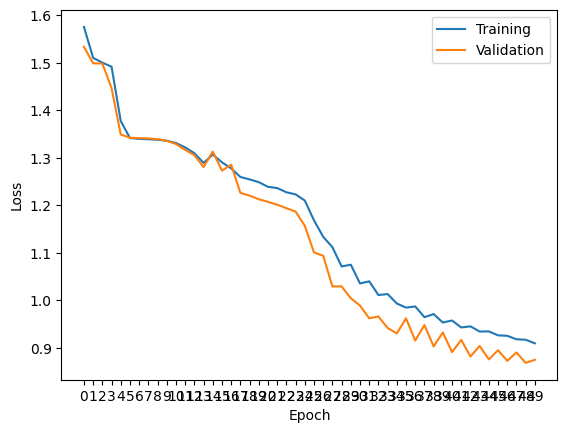


Finished Training, Testing on test set


100%|██████████| 114/114 [00:02<00:00, 46.02it/s]



 0.9106276168635017

Generating Unlabeled Result


100%|██████████| 114/114 [00:01<00:00, 83.92it/s]


AP = 0.523800987531587
AP = 0.7236443652041791
AP = 0.04364866098892022
AP = 0.7793651072298734
AP = 0.054823678457664025
Average Precision (all classes) = 0.4250565598824448
CPU times: user 22min 17s, sys: 7.03 s, total: 22min 24s
Wall time: 26min 23s


In [29]:
%%time
criterion = nn.CrossEntropyLoss()
##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
num_epoch = 50
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

print('\nStart training')
trn_hist = []
val_hist = []
for epoch in range(num_epoch): #TODO: Change the number of epochs
  print('-----------------Epoch = %d-----------------' % (epoch+1))
  trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
  print('Validation loss: ')
  val_loss = test(val_loader, net, criterion, device)
  trn_hist.append(trn_loss)
  val_hist.append(val_loss)

plot_hist(trn_hist, val_hist)
##########################################################################
# TODO: Submit the "Average Precision(all classes)" value in the report  #
##########################################################################
print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')
##############################################################################
# You can visualize your segmentation results using get_results function     #
# Your result will be dumped in the folder 'output_test'.                    #
# There will be three files for each image:                                   # 
#   (1) gt<num>.png (ground truth label)                                     #
#   (2) x<num>.png (input RGB image)                                         #
#   (3) y<num>.png (predicted output)                                        #
#                                                                            #
# TODO: Find a satisfactory result by running the next cell and report       #
#       the plot of gt<num>.png, x<num>.png and y<num>.png in the pdf        #
# Note: Your submission doesn't have to be perfect.                          #
##############################################################################
result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_{}.pth'.format(name))

cal_AP(ap_loader, net, criterion, device)

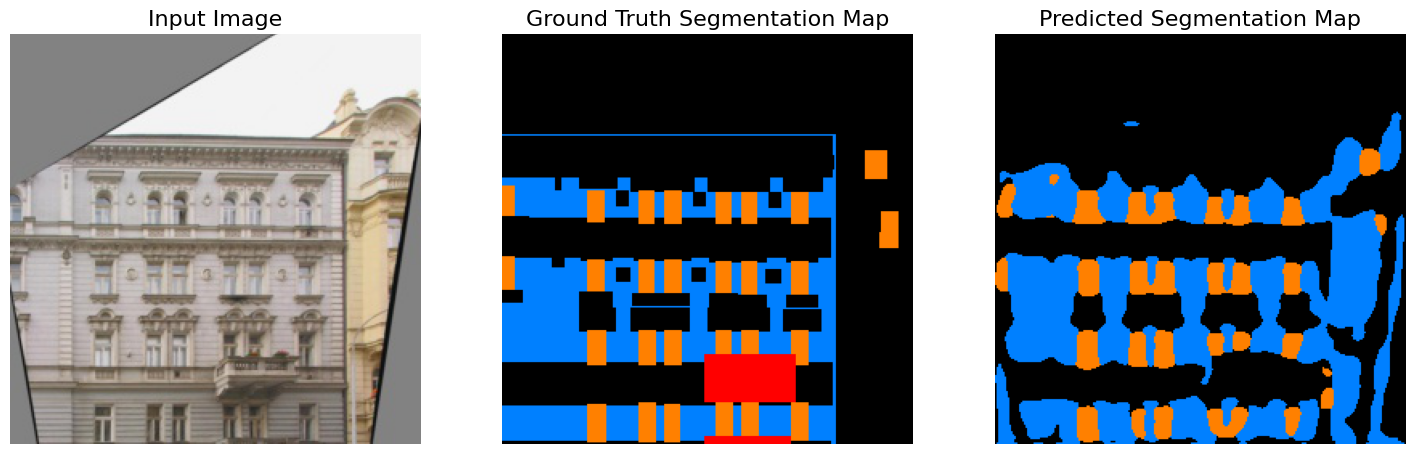

In [30]:
########################################################################
# TODO: Find a satisfactory result from the 114 test images            #
#       Submit the result in the pdf                                   #
# Note: Your submission doesn't have to be perfect.                    #
########################################################################
img_idx = 1
########################################################################
#                             END OF YOUR CODE                         #
########################################################################
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

## Acknowledgement
The Mini Facade dataset are modified from CMP Facade Database by $Radim \ Tyle \check{c}ek$ and $Radim \ \check{S}a^{'}ra$. And the starter code are modified from EECS 442 taught by Professor  David Fouhey  from University of Michigan.